In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [4]:
# Define features and target
categorical_cols = ['season', 'is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'season', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [5]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [6]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [7]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols

# Prior

In [8]:
stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

In [11]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model = CmdStanModel(stan_file=linear_regression)
prior_fit = model.sample(data=stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

15:29:27 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression
15:43:40 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression
15:43:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

15:44:04 - cmdstanpy - INFO - CmdStan done processing.


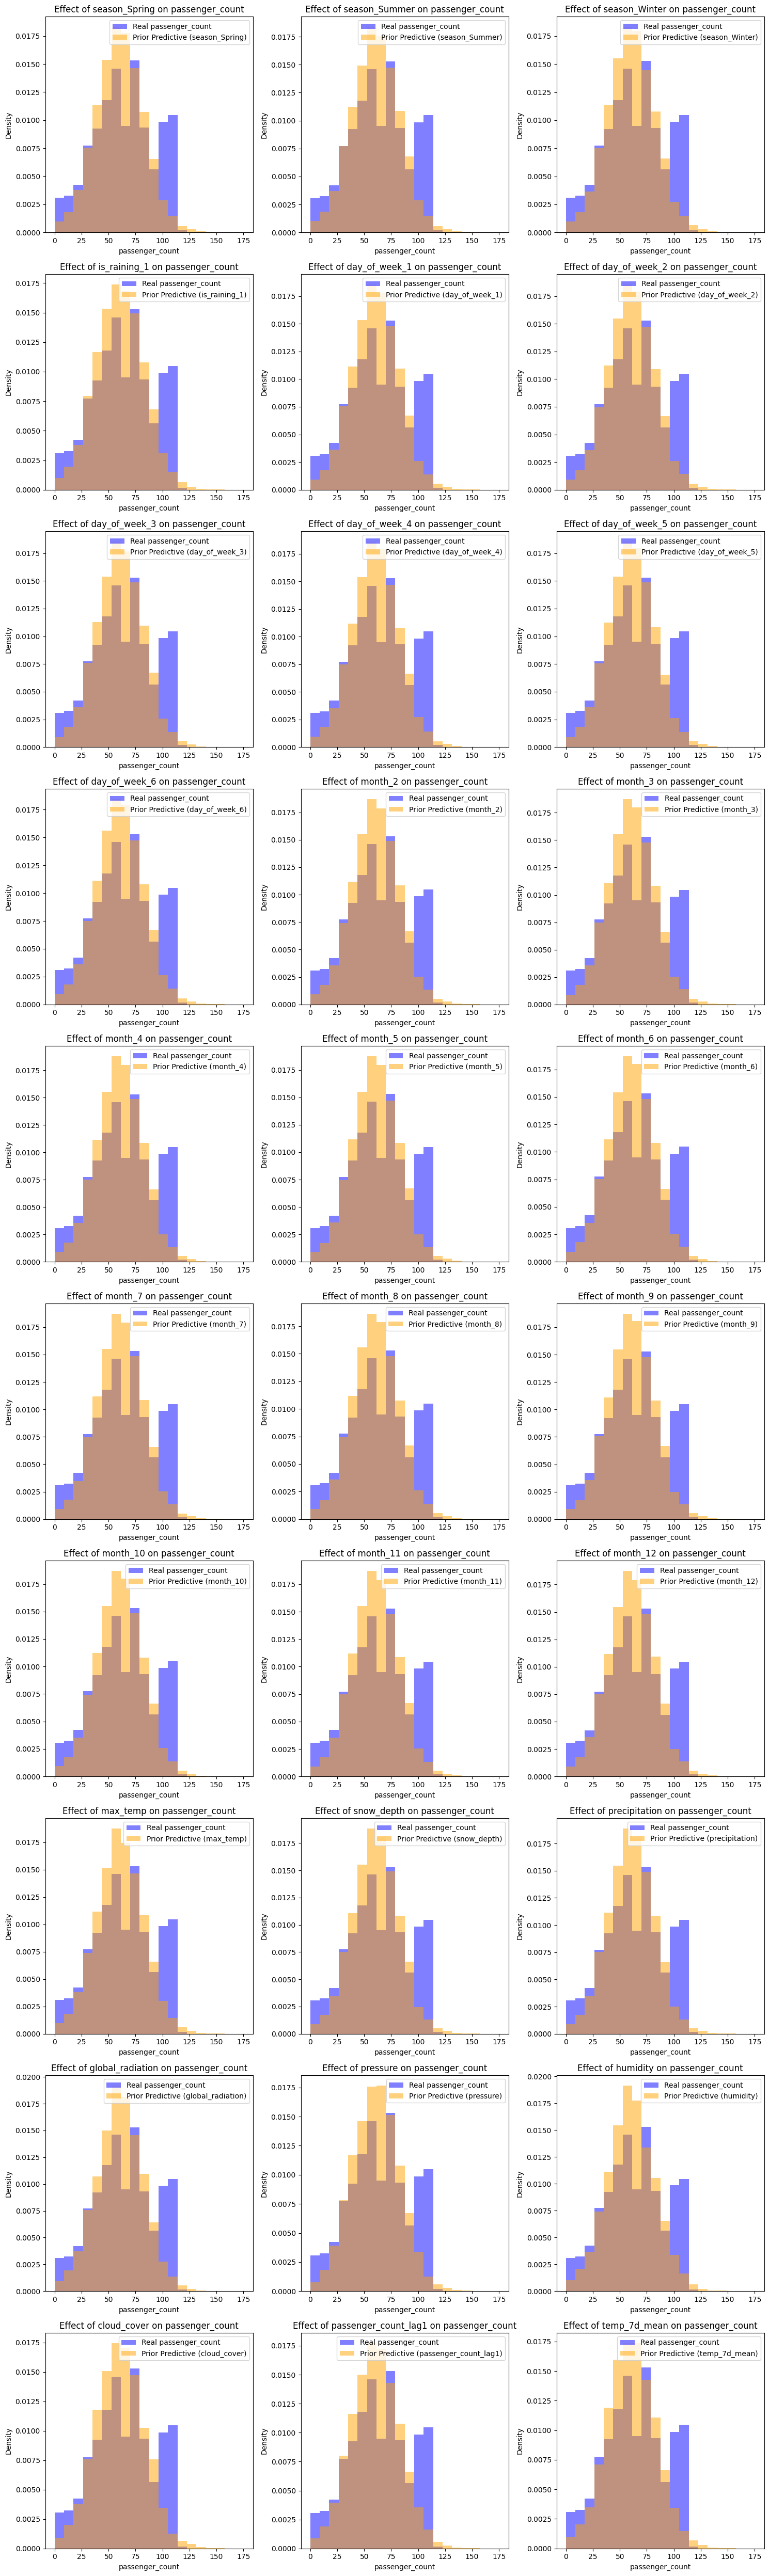

In [12]:
# Extract prior predictive samples
y_prior = prior_fit.stan_variable('y').flatten()  # Shape: (n_samples * N,)
y_per_feature = prior_fit.stan_variable('y_per_feature')  # Shape: (n_samples, K, N)
real_data = y_train.values

# Visualization: Histograms for real and prior predictive passenger_count for each feature
n_features = len(feature_names)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=min(n_features, 3), figsize=(15, 5 * ((n_features + 2) // 3)))
axes = axes.flatten() if n_features > 1 else [axes]
bin_range = (0, real_data.max() * 1.5)
# Plot for each feature
for idx, feature in enumerate(feature_names):
    # Extract prior predictive samples for this feature (flatten across samples and observations)
    y_feature = y_per_feature[:, idx, :].flatten()  # Shape: (n_samples * N,)

    # Plot histograms with plt.hist
    axes[idx].hist(real_data, bins=20, density=True, alpha=0.5, label='Real passenger_count', color='blue', 
                   range=bin_range, histtype='stepfilled')
    axes[idx].hist(y_feature, bins=20, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', 
                   range=bin_range, histtype='stepfilled')
    
    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Posterior

In [ ]:
# Prepare data for Stan
fit_stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values,
    'N_new': len(X_test_transformed) if len(X_test_transformed) > 0 else 0,
    'X_new': X_test_transformed if len(X_test_transformed) > 0 else np.zeros((0, len(feature_names)))
}

In [ ]:
# Define Stan model
stan_code = """
data {
  int<lower=0> N;          // Number of training samples
  int<lower=0> K;          // Number of features
  matrix[N, K] X;          // Feature matrix
  vector[N] y;             // Target variable
  int<lower=0> N_new;      // Number of test samples
  matrix[N_new, K] X_new;  // Test feature matrix
}
parameters {
  vector[K] beta;          // Regression coefficients
  real beta0;              // Intercept
  real<lower=0> sigma;     // Noise standard deviation
}
model {
  // Priors
  beta0 ~ normal(0, 5);
  beta ~ normal(0, 5);
  sigma ~ cauchy(0, 2.5);

  // Likelihood
  y ~ normal(X * beta + beta0, sigma);
}
generated quantities {
  vector[N_new] y_pred;    // Predictions for test data
  for (n in 1:N_new) {
    y_pred[n] = normal_rng(X_new[n] * beta + beta0, sigma);
  }
}
"""
# Save Stan model
with open('linear_regression.stan', 'w') as f:
    f.write(stan_code)

In [ ]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model = CmdStanModel(stan_file=linear_regression)
fit = model.sample(data=fit_stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

In [ ]:
# Check sampling diagnostics
summary = fit.summary()

# Print available columns in the summary DataFrame
print("Summary DataFrame columns:", summary.columns.tolist())

rhat = summary['R_hat'].max()

# Check if 'N_Eff' column exists before accessing it
if 'N_Eff' in summary.columns:
    n_eff = summary['N_Eff'].min()
    print(f"Sampling Diagnostics: Max R-hat = {rhat:.4f}, Min N_Eff = {n_eff:.0f}")
    if rhat > 1.1 or n_eff < 100:
        print("Warning: Sampling issues detected. Consider increasing iter_sampling or adapt_delta.")
else:
    print(f"Sampling Diagnostics: Max R-hat = {rhat:.4f}. N_Eff column not found in summary.")
    if rhat > 1.1:
         print("Warning: High R-hat detected. Sampling issues likely. Consider increasing iter_sampling or adapt_delta.")

In [ ]:
# Posterior predictive analysis
if len(X_test_transformed) > 0:
    y_pred = fit.stan_variable('y_pred').mean(axis=0)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Posterior Predictive Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    # Check consistency
    y_pred_samples = fit.stan_variable('y_pred')
    credible_intervals = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)
    within_ci = np.mean((y_test >= credible_intervals[0]) & (y_test <= credible_intervals[1]))
    print(f"Proportion of test data within 95% credible intervals: {within_ci:.2f}")
    if within_ci < 0.9:
        print("Warning: Less than 90% of test data within credible intervals. Model may miss non-linear effects or key features.")

In [ ]:
# Parameter marginal distributions
beta_samples = fit.stan_variable('beta')
beta0_samples = fit.stan_variable('beta0')
sigma_samples = fit.stan_variable('sigma')
print("\nParameter Summaries:")
for i, name in enumerate(feature_names):
    mean, std = beta_samples[:, i].mean(), beta_samples[:, i].std()
    ci = np.percentile(beta_samples[:, i], [2.5, 97.5])
    print(f"{name}: Mean = {mean:.4f}, SD = {std:.4f}, 95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
print(f"beta0: Mean = {beta0_samples.mean():.4f}, SD = {beta0_samples.std():.4f}, 95% CI = [{np.percentile(beta0_samples, 2.5):.4f}, {np.percentile(beta0_samples, 97.5):.4f}]")
print(f"sigma: Mean = {sigma_samples.mean():.4f}, SD = {sigma_samples.std():.4f}, 95% CI = [{np.percentile(sigma_samples, 2.5):.4f}, {np.percentile(sigma_samples, 97.5):.4f}]")

In [ ]:
# Plot parameter histograms
plt.figure(figsize=(12, 8))
for i, name in enumerate(feature_names):  # Plot first 4 for brevity
    plt.subplot(10, 4, i+1)
    plt.hist(beta_samples[:, i], bins=30, density=True)
    plt.title(f'{name}')
    plt.xlabel('Value')
    plt.ylabel('Density')
plt.tight_layout()
plt.savefig('parameter_histograms.png')
plt.show()